# TP1 Apprentissage Signaux Sociaux - Doriand Petit

à envoyer à : LEBRUN@ISIR.UPMC.FR

De Doriand Petit - doriand.petit@etu.sorbonne-universite.fr

#### Imports :

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print(len(os.listdir("./BabyEars_WAV")))
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
import sklearn.metrics

2042


#### Data Processing :

In [2]:
def create_data(folder,lab,types = "Baby"):
    extract = []
    if types =="Baby" :
        files = os.listdir(folder)
        ### Remove Mat Files
        files.pop(-1)
        files.pop(-1)
        files.pop(-1)
        files.pop(-1)
        files.pop(-1)
        files.pop(-1)

        #print((files))
        while files != [] :
            extract.append(files[0:4])
            files.pop(0)
            files.pop(0)
            files.pop(0)
            files.pop(0)
            
    if types =="Kismet" :
        files = os.listdir(folder)
        for f in files :
            if f[-4:] == ".mat" :
                files.remove(f)
        while files != [] :
            extract.append(files[0:2])
            files.pop(0)
            files.pop(0)
            files.pop(0)
            
    ### Remove Files of Labels not Wanted
    k=0
    extract = np.array(extract)
    KList=[]
    #print((extract.shape))
    for f in extract :
        k+=1
        #print("BEFORE : ",f[0][6:8])
        if not(f[0][6:8] in lab) :
            #print("REMOVE : ",f[0][6:8])
            KList.append(k-1)
    extract = np.delete(extract,KList,axis=0)
    return extract


def create_labels(extract,types="Baby") :
    labels = []
    if types == "Baby" :

        for data in extract :
            if data[0][6:8] in ["ap","at","pr"] :
                labels.append(data[0][6:8])
            
    if types == "Kismet" :

        for data in extract :
            if data[0][6:8] in ["ap","at","pw"] :
                labels.append(data[0][6:8])
    return labels
    
print(len(create_data("./BabyEars_WAV",["ap","pr"],types = "Baby")))


360


## Exercice 1 :

##### 1. and 2. Extractions des features prosodiques et de leurs fonctionnels

In [3]:
def prosodic(files,path,voiced = 0) :
    '''
    Si voiced = 0, on prend tout l'enregistrement ;
    Si voiced = 1, on prend les parties voisées ;
    Si voiced = 2, on prend les parties non voisées.
    
    '''
        
    f0=[]
    en = []
    if voiced == 0 :
        for f in files :
            if f[-2:] == "f0" :
                freq = open(path+f, "r")
                for line in freq :
                    f0.append(int(line[5:]))
                freq.close()
                
            if f[-2:] == "en" :
                ener = open(path+f, "r")
                for line in ener :
                    en.append(int(line[5:]))
                ener.close()
    if voiced == 1 or voiced == 2:
        Klist=[]
        for f in files :
            if f[-2:] == "f0" :
                freq = open(path+f, "r")
                k = 0
                for line in freq :
                    if (int(line[5:]) != 0 and voiced ==1) or (int(line[5:]) == 0 and voiced ==2) :
                        f0.append(int(line[5:])) 
                        Klist.append(k)
                    k+=1
                freq.close()
            #print("KLIST",Klist)
        for f in files :
            if f[-2:] == "en" :
                ener = open(path+f, "r")
                k=0
                for line in ener :
                    #print(k in Klist,k,Klist)
                    if (k in Klist):
                        #print("OK")
                        en.append(int(line[5:]))
                    k+=1
                ener.close()
        #print(Klist)
    #print(len(f0),len(en))
    return(f0,en)

def statistics(l):
    arr = np.array(l)
    
    stats=[]
    stats.append(arr.mean())              ## Moyenne
    stats.append(np.median(arr))          ## Médiane
    stats.append(np.percentile(arr,25))   ## 25%
    stats.append(np.percentile(arr,75))   ## 75%
    stats.append(np.max(arr))             ## Valeur Max
    stats.append(np.std(arr))             ## Standard Deviation
    stats.append(len(arr))                ## Longueur du signal
    summ=0                                ## Mean Absolute of local derivate
    for k in range(1,len(arr)) :
        summ += np.abs(arr[k] - arr[k-1]) / (0.02*(len(arr)-1))
    stats.append(summ)
    return(stats)
                

### 4) 5) 6) Fonction Générale qui utilisent les anciennes fonctions pour créer les vecteurs X et y :

In [4]:
def create(folder,lab,types="Baby",v=0) :
    if types == "Baby" :
        path = "./BabyEars_WAV/"
    else :
        path = "./Kismet_data/"
    
    if types == "Baby" :
        extract = create_data(folder,lab,types)
        
        labels = create_labels(extract,types)
    else :
        extract = create_data(folder,lab,types)
        labels = create_labels(extract,types)
    
    functionnals = []
    
    for files in extract :
        f0,en = prosodic(files,path,voiced=v)
        stats_f0 = statistics(f0)
        stats_en = statistics(en)
        functionnals.append(stats_f0+stats_en)
    return (functionnals,labels)
        

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

X,y = create("./Kismet_data",["ap","pw"],types = "Kismet",v=0)  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet: ",clf.score(X_test,y_test))
print(confusion_matrix(y_test,clf.predict(X_test)))


X,y = create("./BabyEars_WAV",["ap","pr"],types = "Baby",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf.fit(X_train, y_train)
print("SVM Classifier Score Baby : ",clf.score(X_test,y_test))
print(confusion_matrix(y_test,clf.predict(X_test)))

(373, 16) (373,)
SVM Classifier Score Kismet:  0.9666666666666667
[[76  2]
 [ 3 69]]
SVM Classifier Score Baby :  0.6388888888888888
[[61 29]
 [23 31]]


### Commentaires et Remarques sur ces résultats :

En prenant en compte le fait que aucune optimisation (cross-validation par exemple) des hyperparamètres n'a été réalisée, nous obtenons de très bons résultats sur Kismet, mais des résultats plus mitigés sur Baby. Une explication pourrait être que les participants devant le robot Kismet, ont plus forcé leurs intonations que face à un bébé car il n'est aujourd'hui pas très naturel de parler à un robot et il subsiste une appréhension quant à sa faculté de compréhension. 

Nous pouvons remarquer que le nombre d'extraits n'étant pas très grand, le rapport train set - test set est assez important. En effet, avoir plus de données pour s'entraîner permet d'obtenir une meilleure précision, et donc réduire le paramètre test_size peut être très bénéfique.


J'utilise ci-dessous un random forest classifier afin de regarder l'importance de chaque feature grâce à l'attribut feature_importances_ de ce classifier. Cela nous permet de voir l'importance de f0 et de l'énergie ainsi que des différentes statistiques :


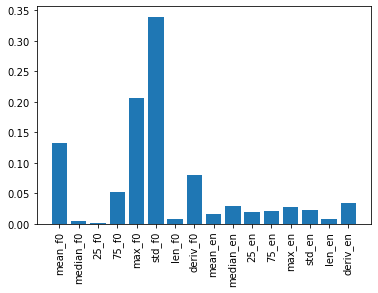

Random Forest Classifier Score Kismet:  0.9533333333333334


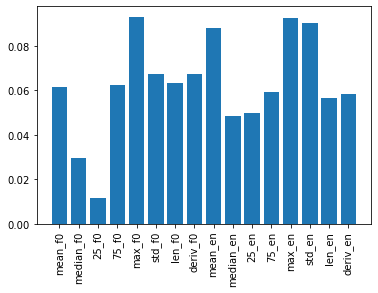

Random Forest Classifier Score Baby:  0.6527777777777778


In [6]:
from sklearn.ensemble import RandomForestClassifier

X,y = create("./Kismet_data",["ap","pw"],types = "Kismet",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)


names = ["mean_f0","median_f0","25_f0","75_f0","max_f0","std_f0","len_f0","deriv_f0","mean_en","median_en","25_en","75_en","max_en","std_en","len_en","deriv_en"]


plt.bar(names,forest.feature_importances_)
plt.xticks(rotation=90)
plt.show()
    
print("Random Forest Classifier Score Kismet: ",forest.score(X_test,y_test))

X,y = create("./BabyEars_WAV",["ap","pr"],types = "Baby",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

plt.bar(names,forest.feature_importances_)
plt.xticks(rotation=90)
plt.show()
    
print("Random Forest Classifier Score Baby: ",forest.score(X_test,y_test))

Nous obtenons tout d'abord un score excellent pour Kismet et un score décevant pour Baby (obtenus tous deux sans optimisation des hyperparamtres). On remarque d'ailleurs qu'ils sont proches de ce que l'on obtenait avec SVM. Une dernière remarque avant de commenter les graphiques : les résultats (scores ET feature importances) varient de manière conséquentes à chaque exécution.

On voit que les feature importances sont très différentes entre Baby et Kismet, où les features de ce premier sont globalement équilibrées (sauf exceptions) alors que le classifier de Kismet utilise principalement la moyenne, le max et le std de f0 (pour obtenir un socre proche d'être parfait). C'est assez étonnant de voir une telle différence entre les deux datasets. Il est probable que la raison soit la même que celle évoquée pour le score : les personnes ont plus forcé leurs intonations pour le robot qu'au naturel.

D'ailleurs pour Kismet, il est intéressant de réfléchir au sens de cette domination des 3 features, et de la faible importance de l'énergie. La hauteur de la voix en moyenne, maximum et sa variation est suffisante pour classer entre Approval et Prohibition, ce qui n'est pas si étonnant en y réfléchissant.

Pour finir voici les résultats pour d'autres couples de labels :

In [7]:
X,y = create("./Kismet_data",["at","pw"],types = "Kismet",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet AT/PW: ",clf.score(X_test,y_test))

X,y = create("./BabyEars_WAV",["at","pr"],types = "Baby",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf.fit(X_train, y_train)
print("SVM Classifier Score Baby AT/PR: ",clf.score(X_test,y_test))

X,y = create("./Kismet_data",["at","ap"],types = "Kismet",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet AT/AP : ",clf.score(X_test,y_test))

X,y = create("./BabyEars_WAV",["at","ap"],types = "Baby",v=0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf.fit(X_train, y_train)
print("SVM Classifier Score Baby AT/AP : ",clf.score(X_test,y_test))

SVM Classifier Score Kismet AT/PW:  0.971830985915493
SVM Classifier Score Baby AT/PR:  0.6554621848739496
SVM Classifier Score Kismet AT/AP :  0.8014184397163121
SVM Classifier Score Baby AT/AP :  0.7172413793103448




#### 3. Concernant les segments non-voisés (f0=0) :   

Les statistiques de f0 sont toutes nulles, et seul l'énergie nous intéresse, nous perdons donc beaucoup d'information. D'après l'analyse de feature_importances précédente, on imagine que c'est une grosse perte et qu'il préférable de garder uniquement les segments voisés dans le cas où on ne peut garder qu'une partie. 


Essayons d'appliquer le processus complet (avec classifier SVM classique) sur les parties voisées uniquement et les parties non-voisées uniquement :


In [8]:
X,y = create("./Kismet_data",["ap","pw"],types = "Kismet",v=1)  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Voisées Uniquement : ",clf.score(X_test,y_test))

(373, 16) (373,)
SVM Classifier Score Voisées Uniquement :  0.9533333333333334


In [9]:
X,y = create("./Kismet_data",["ap","pw"],types = "Kismet",v=2)  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Non-Voisées Uniquement : ",clf.score(X_test,y_test))

(373, 16) (373,)
SVM Classifier Score Non-Voisées Uniquement :  0.6133333333333333


Comme prévu, nous obtenons un score bien plus faible pour les non-voisés uniquement, et un score proche du score original pour les voisés uniquement. On peut d'ailleurs remarquer que le score du non-voisés reste meilleur qu'un random guess, l'information restante n'est pas inutile pour autant.

### Exercice 2 :

In [10]:
X,y = create("./Kismet_data",["ap","at","pw"],types = "Kismet")  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet : ",clf.score(X_test,y_test))

X,y = create("./BabyEars_WAV",["ap","at","pr"],types = "Baby")  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Baby : ",clf.score(X_test,y_test))

(539, 16) (539,)
SVM Classifier Score Kismet :  0.875
(509, 16) (509,)
SVM Classifier Score Baby :  0.553921568627451


Nous observons des résultats un peu moins bons que avec 2 classes. C'est compréhensible, de par le fait qu'il est plus difficile de classifier 3 classes contre 2. On peut cependant aussi se rappeler que ajouter cette 3ème classe rajoute des données (la 3ème classe ne provient pas des 2 premières), ce qui est une bonne chose pour notre classifier. 

Notamment le score est assez mauvais pour Baby (le random guess ne correspond pas à un score de 0.5 mais de un tiers).

### Exercice 3 :

#### Intra Condition :

C'est ce que nous avons déjà réalisé précédemment (train et test sur le même dataset), je remets les scores pour effectuer des comparaisons ensuite.

In [12]:
X,y = create("./Kismet_data",["ap","at","pw"],types = "Kismet")  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet : ",clf.score(X_test,y_test))

X,y = create("./BabyEars_WAV",["ap","at","pr"],types = "Baby")  
print(np.array(X).shape,np.array(y).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Baby : ",clf.score(X_test,y_test))

(539, 16) (539,)
SVM Classifier Score Kismet :  0.875
(509, 16) (509,)
SVM Classifier Score Baby :  0.553921568627451


#### Cross-Corpus Condition :

Remarque : Nous considérons ici que Prohibition de Baby est équivalent à la classe Prohibition Weak de Kismet, il faut donc remplacer le label pw en pr si nous voulons utiliser les databases ensemble en train/test.

Ici, on entraine sur un dataset et on test sur les 2 datasets séparément :

In [13]:
def replace_labels(y,old="pw",new="pr") :
    y = np.array(y)
    return(np.where(y==old, new, y))

In [24]:
X1,y1 = create("./BabyEars_WAV",["ap","at","pr"],types = "Baby")  

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X1,y1)

X2,y2 = create("./Kismet_data",["ap","at","pw"],types = "Kismet")  

y2 = replace_labels(y2)

print("SVM Classifier Score Trained on Baby and tested on Kismet: ",clf.score(X2,y2))

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X2,y2)

print("SVM Classifier Score Trained on Kismet and tested on Baby: ",clf.score(X1,y1))

SVM Classifier Score Trained on Baby and tested on Kismet:  0.36363636363636365
SVM Classifier Score Trained on Kismet and tested on Baby:  0.3948919449901768


Nous observons des résultats très mauvais, ce qui peut être assez étonnant. Nous sommes tout juste meilleur qu'un random choice. Il est logique d'obtenir une perte de score de par la différence des audios et de la manière de classifier en fonction des trainings, mais c'est quand même suprenant d'obtenir une telle perte.

#### Pooling Condition

In [18]:
X1,y1 = create("./Kismet_data",["ap","at","pw"],types = "Kismet")  
X2,y2 = create("./BabyEars_WAV",["ap","at","pr"],types = "Baby")  
y2 = list(replace_labels(y2))

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4)

X_train = X1_train + X2_train
y_train = y1_train+y2_train


clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Kismet : ",clf.score(X1_test,y1_test))
print("SVM Classifier Score Baby : ",clf.score(X2_test,y2_test))



SVM Classifier Score Kismet :  0.8009259259259259
SVM Classifier Score Baby :  0.4852941176470588


Ici, on concatène les deux bases de données, et on obtient des résultats bien meilleurs qu'avant (bien que loin d'être très bon pour autant, et même moins bons que précédemment). C'est plutôt logique car nous avons alors environ deux fois plus de données pour l'entraînement notamment, ce qui va grandement aider le classifier. Cependant, puisque les audios Kismet et Baby semblent assez différents (pour un classifier cf feature importance), il n'est pas étonnant de voir de moins bons résultats qu'en intra-condition.

## Ajout Final Classifier pour détecter si un audio est pour Kismet ou au naturel pour un bébé

In [20]:
X1,y1 = create("./Kismet_data",["ap","at","pw"],types = "Kismet")  
X2,y2 = create("./BabyEars_WAV",["ap","at","pr"],types = "Baby")  
y2 = list(replace_labels(y2))

X = X1+X2
y = np.zeros((len(X)))
y[len(X1)+1:] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) 



clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

print("SVM Classifier Score Détection Kismet/Baby : ",clf.score(X_test,y_test))

SVM Classifier Score Détection Kismet/Baby :  0.9642857142857143
